In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from datetime import timedelta
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
import numpy as np
import gymnasium as gym
import random
from gymnasium import Env
from gymnasium import spaces

In [19]:
file_path = 'zip://clustered_data_4months.zip!clustered_data_4months (2).geojson'
data = gpd.read_file(file_path, driver="GeoJSON")

# Convert 'time' to datetime and sort by time
data['time'] = pd.to_datetime(data['time'])
data = data.sort_values('time').reset_index(drop=True)

# Create time_step as an ordinal index
data['time_step'] = data.index

print(data.head())
print(data.columns)
print(len(data))
print(len(data[data['cnprcp_mean']>0]))

/Users/shashwatraj/Documents/GitHub/Code-Lab_RL_PriorityObs/tatcenv/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


                       time satellite instrument    swath_width  valid_obs  \
0 2024-05-22 00:00:00+00:00      Test       Test  278640.704057       True   
1 2024-05-22 00:02:00+00:00      Test       Test  277041.710508       True   
2 2024-05-22 00:04:00+00:00      Test       Test  275419.732317       True   
3 2024-05-22 00:06:00+00:00      Test       Test  273866.283658       True   
4 2024-05-22 00:08:00+00:00      Test       Test  272466.738302       True   

   solar_hour time_range  month    lat_sat     lon_sat  cnprcp_mean  \
0    9.006320    morning      5 -38.142798  134.265144          0.0   
1    9.495089    morning      5 -33.073314  141.096599          0.0   
2    9.929164    morning      5 -27.614694  147.107611          0.0   
3   10.321410    morning      5 -21.873562  152.491185          0.0   
4   10.683133    morning      5 -15.932572  157.416882          0.0   

                                            geometry  time_step  
0  POLYGON Z ((135.51668 -38.1428 0, 1

In [20]:
world = gpd.read_file('110m_cultural.zip', layer='ne_110m_admin_0_boundary_lines_land')
geometry = [Point(xy) for xy in zip(data['lon_sat'], data['lat_sat'])]
geo_full = gpd.GeoDataFrame(data, geometry=geometry)
geo_full['ground_track'] = geo_full.apply(lambda row: 0 if world.contains(row.geometry).any() else 1, axis=1)
data['ground_track'] = geo_full['ground_track']

In [21]:
data['lat_rad'] = np.radians(data['lat_sat'])
data['lon_rad'] = np.radians(data['lon_sat'])
data['x'] = np.cos(data['lat_rad']) * np.cos(data['lon_rad'])
data['y'] = np.cos(data['lat_rad']) * np.sin(data['lon_rad'])
data['z'] = np.sin(data['lat_rad'])

In [22]:
encoder = OneHotEncoder(sparse_output=False)
time_range_encoded = encoder.fit_transform(data[['time_range']])
time_range_feature_names = encoder.get_feature_names_out(['time_range'])
time_range_df = pd.DataFrame(time_range_encoded, columns=time_range_feature_names, index=data.index)
data = pd.concat([data, time_range_df], axis=1)

In [23]:
scaler = MinMaxScaler()
cols_to_scale = ['x', 'y', 'z', 'cnprcp_mean']
scaled_values = scaler.fit_transform(data[cols_to_scale])
data['x_norm'] = scaled_values[:, 0]
data['y_norm'] = scaled_values[:, 1]
data['z_norm'] = scaled_values[:, 2]
data['cnprcp_norm'] = scaled_values[:, 3]

In [24]:
def compute_orbit_ids(df, lon_threshold=358):
    
    df = df.copy()
    orbit_id = 0
    orbit_ids = [orbit_id]
    prev_lon = df.iloc[0]['lon_sat']
    for idx in range(1, len(df)):
        curr_lon = df.iloc[idx]['lon_sat']
        # Handle wrap-around: e.g., near 180 and -180 are close
        diff = abs(curr_lon - prev_lon)
        if diff > lon_threshold:
            orbit_id += 1
        orbit_ids.append(orbit_id)
        prev_lon = curr_lon
    df['orbit_id'] = orbit_ids
    return df

data = compute_orbit_ids(data, lon_threshold=300)

print("Number of orbits found:", data['orbit_id'].nunique())

Number of orbits found: 1448


In [25]:
class SatelliteEnv(gym.Env):
    def __init__(self, df):
        super(SatelliteEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.n_steps = len(self.df)
        

        # Action space: 0 = don't act, 1 = act.
        self.action_space = spaces.Discrete(2)

        # One-hot encoded time_range columns.
        self.one_hot_cols = [col for col in df.columns if col.startswith('time_range_')]
        n_one_hot = len(self.one_hot_cols)

        self.obs_dim = 4 + n_one_hot
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(self.obs_dim,), dtype=np.float32)
        self._index = 0


    def reset(self, seed=None, options=None):
        self._index = 0
        return self._get_obs(), {}
    
    def step(self, action):
        reward = self._compute_reward(action)
        self._index += 1
        done = (self._index >= self.n_steps - 1)
        obs = self._get_obs() if not done else np.zeros(self.obs_dim, dtype=np.float32)
        terminated = done  # assuming episode termination
        truncated = False  # assuming no truncation
        return obs, reward, terminated, truncated, {}
    
    def _get_obs(self):
        row = self.df.iloc[self._index]
        # states : x_norm, y_norm, z_norm, ground_track.
        cont_features = np.array([
            row['x_norm'],
            row['y_norm'],
            row['z_norm'],
            float(row['ground_track'])
        ], dtype=np.float32)
        # One-hot encoded time_range features:
        one_hot_features = row[self.one_hot_cols].values.astype(np.float32)
        # Concatenate the encoded vector and state features to form the full state.
        obs = np.concatenate([cont_features, one_hot_features])
        return obs
    
    # Define the Reward Function
    # correct decision*intensity
    def _compute_reward(self, action):
        row = self.df.iloc[self._index]
        cnprcp_mean = row['cnprcp_mean']
        scale = 10000  # scaling factor to amplify small precipitation values
        if action == 1:
            if cnprcp_mean > 0:
                # Correct detection: give a base reward of 1 plus bonus proportional to intensity.
                reward = 1 + (cnprcp_mean * scale)
            else:
                # False positive: a small penalty for acting when there's no precipitation.
                reward = -0.1
        else:  # action == 0
            if cnprcp_mean > 0:
                reward = -0.001 #scale the negative penalty according to the intensity of precipitation
            else:
                reward = 0
        return reward
    
    #visualize reward distribution for the dataset

In [26]:
#For RandomForest model
features = data[['x_norm', 'y_norm', 'z_norm', 'ground_track', 'orbit_id']]
target = (data['cnprcp_mean'] > 0).astype(int)

rf_classifier = RandomForestClassifier(n_estimators=1500, random_state=42, criterion='log_loss')

In [27]:
tscv = TimeSeriesSplit(n_splits=4)

In [28]:
def compute_rf_reward(actual, predicted):
    if actual > 0:
        if predicted == 1:
            return 1
        else:
            return -0.1
    else:
        if predicted == 1:
            return -0.001
        else:
            return 0

In [29]:
all_test_results_random_forest =[]
all_rewards_rf = []

for train_idx, test_idx in tscv.split(features):
    train_features, test_features = features.iloc[train_idx], features.iloc[test_idx]
    train_target, test_target = target.iloc[train_idx], target.iloc[test_idx]

    # Train and Evaluate RF Classifier Model
    rf_classifier.fit(train_features, train_target)
    rf_predictions = rf_classifier.predict(test_features)

    rf_precision = precision_score(test_target, rf_predictions, zero_division=0)
    rf_recall = recall_score(test_target, rf_predictions, zero_division=0)
    rf_f1 = f1_score(test_target, rf_predictions, zero_division=0)
    print(f"RandomForest - Precision: {rf_precision:.2f}")
    print(f"RandomForest - Recall: {rf_recall:.2f}") 
    print(f"RandomForest - F1: {rf_f1:.2f} \n") 

    tmp_df = test_features.copy()
    tmp_df['actual'] = test_target.values
    tmp_df['predicted'] = rf_predictions
    tmp_df['reward'] = tmp_df.apply(lambda row: compute_rf_reward(row['actual'], row['predicted']), axis=1)
    all_rewards_rf.append(tmp_df['reward'].sum())

    all_test_results_random_forest.append(tmp_df)

RandomForest - Precision: 0.18
RandomForest - Recall: 0.05
RandomForest - F1: 0.08 

RandomForest - Precision: 0.19
RandomForest - Recall: 0.01
RandomForest - F1: 0.03 

RandomForest - Precision: 0.31
RandomForest - Recall: 0.05
RandomForest - F1: 0.08 

RandomForest - Precision: 0.21
RandomForest - Recall: 0.10
RandomForest - F1: 0.13 



In [30]:
from stable_baselines3 import A2C
from stable_baselines3.common.env_checker import check_env

all_f1_scores_a2c = []
all_precision_scores_a2c = []
all_recall_scores_a2c = []
all_rewards_a2c = []
all_test_results_a2c  = []


for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(data)):
    train_df = data.iloc[train_idx]
    test_df = data.iloc[test_idx]

    train_env = SatelliteEnv(train_df)
    check_env(train_env, warn=True)


    model = A2C("MlpPolicy", train_env, verbose=0)
    model.learn(total_timesteps=100000)  

    # 4) Evaluate on the test split
    test_env = SatelliteEnv(test_df)
    obs, _ = test_env.reset()

    done = False
    total_reward_a2c = 0.0
    predicted_actions_a2c = []
    actual_labels_a2c = []
    tmp_lat_a2c = []
    tmp_lon_a2c = []
    tmp_test_results_a2c = {'actual': [], 'predicted': [], 'lat': [], 'lon': []}

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        predicted_actions_a2c.append(action)
        
        # Get actual label from cnprcp_mean: 1 if > 0, else 0.
        current_cprcp = test_env.df.iloc[test_env._index]['cnprcp_mean']
        actual_label_a2c = 1 if current_cprcp > 0 else 0
        actual_labels_a2c.append(int(actual_label_a2c))
        tmp_lat_a2c.append(test_env.df.iloc[test_env._index]['lat_sat'])
        tmp_lon_a2c.append(test_env.df.iloc[test_env._index]['lon_sat'])

        obs, reward, terminated, truncated, info = test_env.step(action)
        total_reward_a2c += reward
        done = terminated or truncated

    f1 = f1_score(actual_labels_a2c, predicted_actions_a2c, zero_division=0)
    precision_a2c = precision_score(actual_labels_a2c, predicted_actions_a2c, zero_division=0)
    recall_a2c = recall_score(actual_labels_a2c, predicted_actions_a2c, zero_division=0)
    tmp_test_results_a2c['actual']+= actual_labels_a2c
    tmp_test_results_a2c['predicted']+= predicted_actions_a2c
    tmp_test_results_a2c['lat']+= tmp_lat_a2c
    tmp_test_results_a2c['lon']+= tmp_lon_a2c
    all_test_results_a2c.append(tmp_test_results_a2c)
    all_f1_scores_a2c.append(f1)
    all_precision_scores_a2c.append(precision_a2c)
    all_recall_scores_a2c.append(recall_a2c)
    all_rewards_a2c.append(total_reward_a2c)
    print(f"Fold {fold_idx}: F1_Score = {f1:.3f}, Precision_Score = {precision_a2c:.3f}, Recall_Score = {recall_a2c:.3f}, Total Reward = {total_reward_a2c:.3f}")

mean_f1_a2c = np.mean(all_f1_scores_a2c)
mean_reward_a2c = np.mean(all_rewards_a2c)
print(f"\nOverall: Mean F1 = {mean_f1_a2c:.3f}, Mean Cumulative Reward = {mean_reward_a2c:.3f}")

Fold 0: F1_Score = 0.000, Precision_Score = 0.000, Recall_Score = 0.000, Total Reward = -0.814
Fold 1: F1_Score = 0.000, Precision_Score = 0.000, Recall_Score = 0.000, Total Reward = -0.781
Fold 2: F1_Score = 0.000, Precision_Score = 0.000, Recall_Score = 0.000, Total Reward = -0.759
Fold 3: F1_Score = 0.000, Precision_Score = 0.000, Recall_Score = 0.000, Total Reward = -0.425

Overall: Mean F1 = 0.000, Mean Cumulative Reward = -0.695


In [31]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

all_f1_scores_dqn = []
all_precision_scores_dqn = []
all_recall_scores_dqn = []
all_rewards_dqn = []
all_test_results_dqn  = []


for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(data)):
    train_df = data.iloc[train_idx]
    test_df = data.iloc[test_idx]

    train_env = SatelliteEnv(train_df)
    check_env(train_env, warn=True)


    model = DQN("MlpPolicy", train_env, verbose=0)
    model.learn(total_timesteps=100000)  

    # 4) Evaluate on the test split
    test_env = SatelliteEnv(test_df)
    obs, _ = test_env.reset()

    done = False
    total_reward_dqn = 0.0
    predicted_actions_dqn = []
    actual_labels_dqn = []
    tmp_lat_dqn = []
    tmp_lon_dqn = []
    tmp_test_results_dqn = {'actual': [], 'predicted': [], 'lat': [], 'lon': []}

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        predicted_actions_dqn.append(action)
        
        # Get actual label from cnprcp_mean: 1 if > 0, else 0.
        current_cprcp = test_env.df.iloc[test_env._index]['cnprcp_mean']
        actual_label_dqn = 1 if current_cprcp > 0 else 0
        actual_labels_dqn.append(int(actual_label_dqn))
        tmp_lat_dqn.append(test_env.df.iloc[test_env._index]['lat_sat'])
        tmp_lon_dqn.append(test_env.df.iloc[test_env._index]['lon_sat'])

        obs, reward, terminated, truncated, info = test_env.step(action)
        total_reward_dqn += reward
        done = terminated or truncated

    f1 = f1_score(actual_labels_dqn, predicted_actions_dqn, zero_division=0)
    precision_dqn = precision_score(actual_labels_dqn, predicted_actions_dqn, zero_division=0)
    recall_dqn = recall_score(actual_labels_dqn, predicted_actions_dqn, zero_division=0)
    tmp_test_results_dqn['actual']+= actual_labels_dqn
    tmp_test_results_dqn['predicted']+= predicted_actions_dqn
    tmp_test_results_dqn['lat']+= tmp_lat_dqn
    tmp_test_results_dqn['lon']+= tmp_lon_dqn
    all_test_results_dqn.append(tmp_test_results_dqn)
    all_f1_scores_dqn.append(f1)
    all_precision_scores_dqn.append(precision_dqn)
    all_recall_scores_dqn.append(recall_dqn)
    all_rewards_dqn.append(total_reward_dqn)
    print(f"Fold {fold_idx}: F1_Score = {f1:.3f}, Precision_Score = {precision_dqn:.3f}, Recall_Score = {recall_dqn:.3f}, Total Reward = {total_reward_dqn:.3f}")

mean_f1_dqn = np.mean(all_f1_scores_dqn)
mean_reward_dqn = np.mean(all_rewards_dqn)
print(f"\nOverall: Mean F1 = {mean_f1_dqn:.3f}, Mean Cumulative Reward = {mean_reward_dqn:.3f}")

Fold 0: F1_Score = 0.224, Precision_Score = 0.131, Recall_Score = 0.784, Total Reward = 649.300
Fold 1: F1_Score = 0.185, Precision_Score = 0.106, Recall_Score = 0.736, Total Reward = 467.083
Fold 2: F1_Score = 0.224, Precision_Score = 0.138, Recall_Score = 0.594, Total Reward = 509.538
Fold 3: F1_Score = 0.120, Precision_Score = 0.065, Recall_Score = 0.729, Total Reward = 106.397

Overall: Mean F1 = 0.188, Mean Cumulative Reward = 433.080


In [32]:
from sb3_contrib import QRDQN 
from stable_baselines3.common.env_checker import check_env

all_f1_scores_qrdqn = []
all_precision_scores_qrdqn = []
all_recall_scores_qrdqn = []
all_rewards_qrdqn = []
all_test_results_qrdqn  = []


for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(data)):
    train_df = data.iloc[train_idx]
    test_df = data.iloc[test_idx]

    train_env = SatelliteEnv(train_df)
    check_env(train_env, warn=True)


    model = QRDQN("MlpPolicy", train_env, verbose=0)
    model.learn(total_timesteps=100000)  

    # 4) Evaluate on the test split
    test_env = SatelliteEnv(test_df)
    obs, _ = test_env.reset()

    done = False
    total_reward_qrdqn = 0.0
    predicted_actions_qrdqn = []
    actual_labels_qrdqn = []
    tmp_lat_qrdqn = []
    tmp_lon_qrdqn = []
    tmp_test_results_qrdqn = {'actual': [], 'predicted': [], 'lat': [], 'lon': []}

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        predicted_actions_qrdqn.append(action)
        
        # Get actual label from cnprcp_mean: 1 if > 0, else 0.
        current_cprcp = test_env.df.iloc[test_env._index]['cnprcp_mean']
        actual_label_qrdqn = 1 if current_cprcp > 0 else 0
        actual_labels_qrdqn.append(int(actual_label_qrdqn))
        tmp_lat_qrdqn.append(test_env.df.iloc[test_env._index]['lat_sat'])
        tmp_lon_qrdqn.append(test_env.df.iloc[test_env._index]['lon_sat'])

        obs, reward, terminated, truncated, info = test_env.step(action)
        total_reward_qrdqn += reward
        done = terminated or truncated

    f1 = f1_score(actual_labels_qrdqn, predicted_actions_qrdqn, zero_division=0)
    precision_qrdqn = precision_score(actual_labels_qrdqn, predicted_actions_qrdqn, zero_division=0)
    recall_qrdqn = recall_score(actual_labels_qrdqn, predicted_actions_qrdqn, zero_division=0)
    tmp_test_results_qrdqn['actual']+= actual_labels_qrdqn
    tmp_test_results_qrdqn['predicted']+= predicted_actions_qrdqn
    tmp_test_results_qrdqn['lat']+= tmp_lat_qrdqn
    tmp_test_results_qrdqn['lon']+= tmp_lon_qrdqn
    all_test_results_qrdqn.append(tmp_test_results_qrdqn)
    all_f1_scores_qrdqn.append(f1)
    all_precision_scores_qrdqn.append(precision_qrdqn)
    all_recall_scores_qrdqn.append(recall_qrdqn)
    all_rewards_qrdqn.append(total_reward_qrdqn)
    print(f"Fold {fold_idx}: F1_Score = {f1:.3f}, Precision_Score = {precision_qrdqn:.3f}, Recall_Score = {recall_qrdqn:.3f}, Total Reward = {total_reward_qrdqn:.3f}")

mean_f1_qrdqn = np.mean(all_f1_scores_qrdqn)
mean_reward_qrdqn = np.mean(all_rewards_qrdqn)
print(f"\nOverall: Mean F1 = {mean_f1_qrdqn:.3f}, Mean Cumulative Reward = {mean_reward_qrdqn:.3f}")

Fold 0: F1_Score = 0.150, Precision_Score = 0.084, Recall_Score = 0.751, Total Reward = 346.799
Fold 1: F1_Score = 0.089, Precision_Score = 0.048, Recall_Score = 0.648, Total Reward = -224.385
Fold 2: F1_Score = 0.070, Precision_Score = 0.039, Recall_Score = 0.340, Total Reward = -196.407
Fold 3: F1_Score = 0.072, Precision_Score = 0.038, Recall_Score = 0.720, Total Reward = -235.656

Overall: Mean F1 = 0.095, Mean Cumulative Reward = -77.412


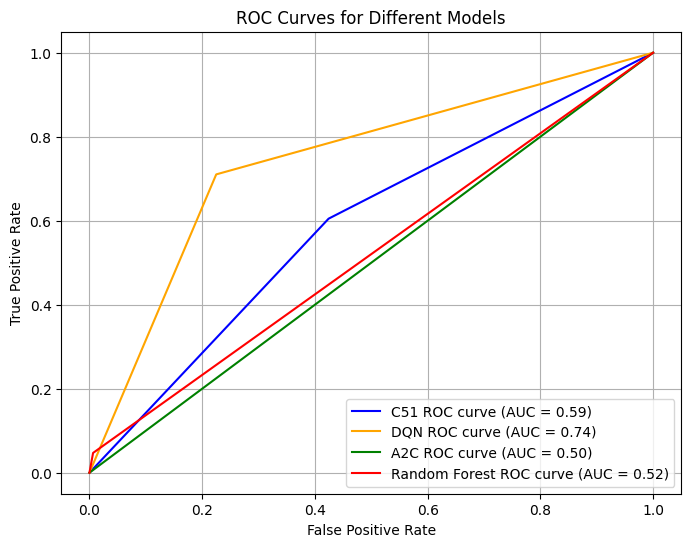

In [33]:
from matplotlib import style
from sklearn.metrics import roc_curve, roc_auc_score

all_actual_qrdqn = []
all_predicted_qrdqn = []
for result in all_test_results_qrdqn:
    all_actual_qrdqn.extend(result["actual"])
    all_predicted_qrdqn.extend(result["predicted"])

fpr_qrdqn, tpr_qrdqn, thresholds = roc_curve(all_actual_qrdqn, all_predicted_qrdqn, pos_label=1)
roc_auc_qrdqn = roc_auc_score(all_actual_qrdqn, all_predicted_qrdqn)

all_actual_dqn = []
all_predicted_dqn = []
for result in all_test_results_dqn:
    all_actual_dqn.extend(result["actual"])
    all_predicted_dqn.extend(result["predicted"])

fpr_dqn, tpr_dqn, thresholds = roc_curve(all_actual_dqn, all_predicted_dqn, pos_label=1)
roc_auc_dqn = roc_auc_score(all_actual_dqn, all_predicted_dqn)

all_actual_a2c = []
all_predicted_a2c = []
for result in all_test_results_a2c:
    all_actual_a2c.extend(result["actual"])
    all_predicted_a2c.extend(result["predicted"])

fpr_a2c, tpr_a2c, thresholds = roc_curve(all_actual_a2c, all_predicted_a2c, pos_label=1)
roc_auc_a2c = roc_auc_score(all_actual_a2c, all_predicted_a2c)

all_actual_rf = []
all_predicted_rf = []
for result in all_test_results_random_forest:
    all_actual_rf.extend(result["actual"])
    all_predicted_rf.extend(result["predicted"])

fpr_rf, tpr_rf, thresholds = roc_curve(all_actual_rf, all_predicted_rf, pos_label=1)
roc_auc_rf = roc_auc_score(all_actual_rf, all_predicted_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_qrdqn, tpr_qrdqn, label=f"C51 ROC curve (AUC = {roc_auc_qrdqn:.2f})", color='blue')
plt.plot(fpr_dqn, tpr_dqn, label=f"DQN ROC curve (AUC = {roc_auc_dqn:.2f})", color='orange')
plt.plot(fpr_a2c, tpr_a2c, label=f"A2C ROC curve (AUC = {roc_auc_a2c:.2f})", color='green')
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest ROC curve (AUC = {roc_auc_rf:.2f})", color='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Models")    
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


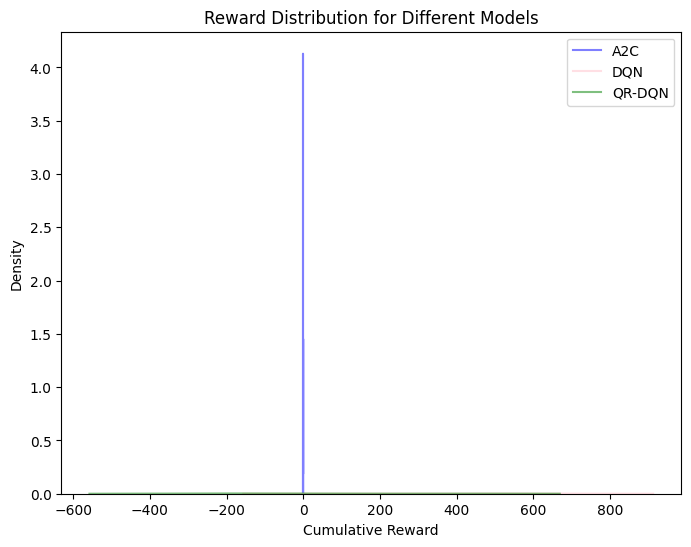

In [34]:
#plt.figure(figsize=(8,6))
%pip install seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(all_rewards_a2c, ax=ax, fill=False, color='blue', alpha=0.5, label='A2C', bw_adjust=0.5)
sns.kdeplot(all_rewards_dqn, ax=ax, fill=False, color='pink', alpha=0.5, label='DQN', bw_adjust=0.5)
sns.kdeplot(all_rewards_qrdqn, ax=ax, fill=False, color='green', alpha=0.5, label='QR-DQN', bw_adjust=0.5)
plt.xlabel("Cumulative Reward")
plt.ylabel("Density")
plt.title("Reward Distribution for Different Models")
plt.legend(loc="upper right")
plt.show()


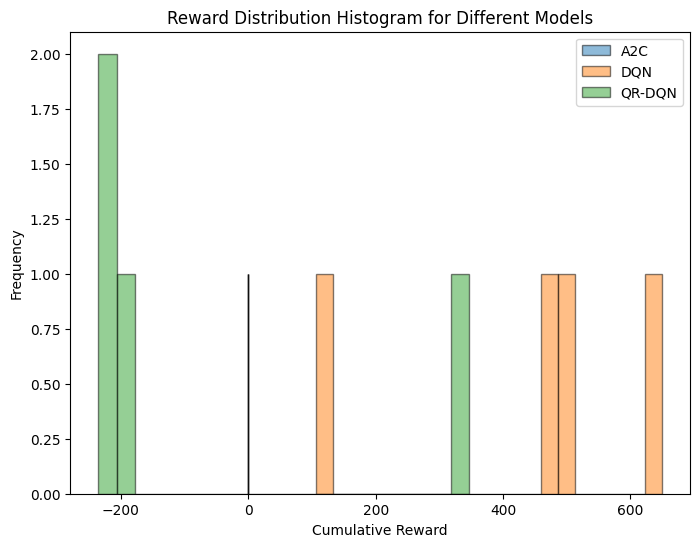

In [35]:
plt.figure(figsize=(8,6))
plt.hist(all_rewards_a2c, bins=20, edgecolor="black", alpha=0.5, label='A2C')
plt.hist(all_rewards_dqn, bins=20, edgecolor="black", alpha=0.5, label='DQN')
plt.hist(all_rewards_qrdqn, bins=20, edgecolor="black", alpha=0.5, label='QR-DQN')
plt.xlabel("Cumulative Reward")
plt.ylabel("Frequency")
plt.title("Reward Distribution Histogram for Different Models")
plt.legend(loc="upper right")
plt.show()
